In [1]:
import sys
sys.path.append("./../../scripts/core/")
import inv_flux as invf

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import pandas as pd

In [3]:
from numpy import pi
r_earth = 6.371e6 # Radius of Earth
dtor = pi/180. # conversion from degrees to radians.

def scalar_earth_area(minlat, maxlat, minlon, maxlon):
    """Returns the area of earth in the defined grid box."""
    
    diff_lon = np.unwrap((minlon,maxlon), discont=360.+1e-6)
    
    return 2.*pi*r_earth**2 *(np.sin( dtor*maxlat) - np.sin(dtor*minlat))*(diff_lon[1]-diff_lon[0])/360.


def earth_area(minlat, maxlat, minlon, maxlon):
    """Returns grid of areas with shape=(minlon, minlat) and earth area."""
    
    result = np.zeros((np.array(minlon).size, np.array(minlat).size))
    diffsinlat = 2.*pi*r_earth**2 *(np.sin(dtor*maxlat) - np.sin(dtor*minlat))
    diff_lon = np.unwrap((minlon,maxlon), discont=360.+1e-6)
    
    for i in range(np.array(minlon).size):
        result[i, :] = diffsinlat *(diff_lon[1,i]-diff_lon[0,i])/360.
    
    return result

def earth_area_grid(lats,lons):
    """Returns an array of the areas of each grid box within a defined set of lats and lons."""
    
    result=np.zeros((lats.size, lons.size))
    
    minlats = lats - 0.5*(lats[1]-lats[0])
    maxlats= lats + 0.5*(lats[1]-lats[0])
    minlons = lons - 0.5*(lons[1]-lons[0])
    maxlons=lons + 0.5*(lons[1]-lons[0])
    
    for i in range(lats.size):
        result[i,:] = scalar_earth_area(minlats[i],maxlats[i],minlons[0],maxlons[0])
    
    return result

In [4]:
def spatial_integration(df):

    values = {'Time':[], 'Land':[]}

    start_time = df.time.values[0].strftime('%Y-%m')
    end_time = df.time.values[-1]
    try:
        next_month = end_time.replace(month=end_time.month+1)
    except ValueError:
        next_month = end_time.replace(year=end_time.year+1, month=1)
    end_time = next_month.strftime('%Y-%m')

    arg_time_range = pd.date_range(start=start_time, end=end_time, freq='M').strftime('%Y-%m')

    lat = df.latitude
    lon = df.longitude
    earth_grid_area = earth_area_grid(lat,lon)

    days = {'01': 31, '02': 28, '03': 31, '04': 30,
            '05': 31, '06': 30, '07': 31, '08': 31,
            '09': 30, '10': 31, '11': 30, '12': 31}

    for index,time_point in enumerate(arg_time_range):

        days_in_month = days[time_point[-2:]]

        earth_land_flux = df['Terrestrial_flux'].sel(time=time_point).values[0]*(days_in_month/365)

        earth_land_sink = earth_grid_area*earth_land_flux

        values['Time'].append(df.sel(time=time_point).time.values[0])
        values['Land'].append(np.sum(1e-15*earth_land_sink))


    return xr.Dataset({'Land': (('time'), values['Land'])},
                      coords={'time': (('time'), values['Time'])})

In [6]:
CAMS = xr.open_dataset("./../../data/inversions/fco2_CAMS-V17-1-2018_June2018-ext3_1979-2017_monthlymean_XYT.nc")
CAMS

<xarray.Dataset>
Dimensions:           (latitude: 180, longitude: 360, time: 468)
Coordinates:
  * longitude         (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude          (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time              (time) object 1979-01-16 00:00:00 ... 2017-12-16 00:00:00
Data variables:
    fossil            (time, latitude, longitude) float32 ...
    Terrestrial_flux  (time, latitude, longitude) float32 ...
    Ocean_flux        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      Thu Apr  4 23:44:41 2019: ncrename -a .FillValue,_FillValue...
    NCO:          "4.6.3"

In [7]:
CAMS_2015 = CAMS.sel(time=slice("2015-01", "2015-12"),
                     latitude=slice(-56.5, 6.5),
                     longitude=slice(89.5, 190.5)
                    )
CAMS_2015

<xarray.Dataset>
Dimensions:           (latitude: 64, longitude: 91, time: 12)
Coordinates:
  * longitude         (longitude) float64 89.5 90.5 91.5 ... 177.5 178.5 179.5
  * latitude          (latitude) float64 -56.5 -55.5 -54.5 -53.5 ... 4.5 5.5 6.5
  * time              (time) object 2015-01-16 00:00:00 ... 2015-12-16 00:00:00
Data variables:
    fossil            (time, latitude, longitude) float32 ...
    Terrestrial_flux  (time, latitude, longitude) float32 ...
    Ocean_flux        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      Thu Apr  4 23:44:41 2019: ncrename -a .FillValue,_FillValue...
    NCO:          "4.6.3"

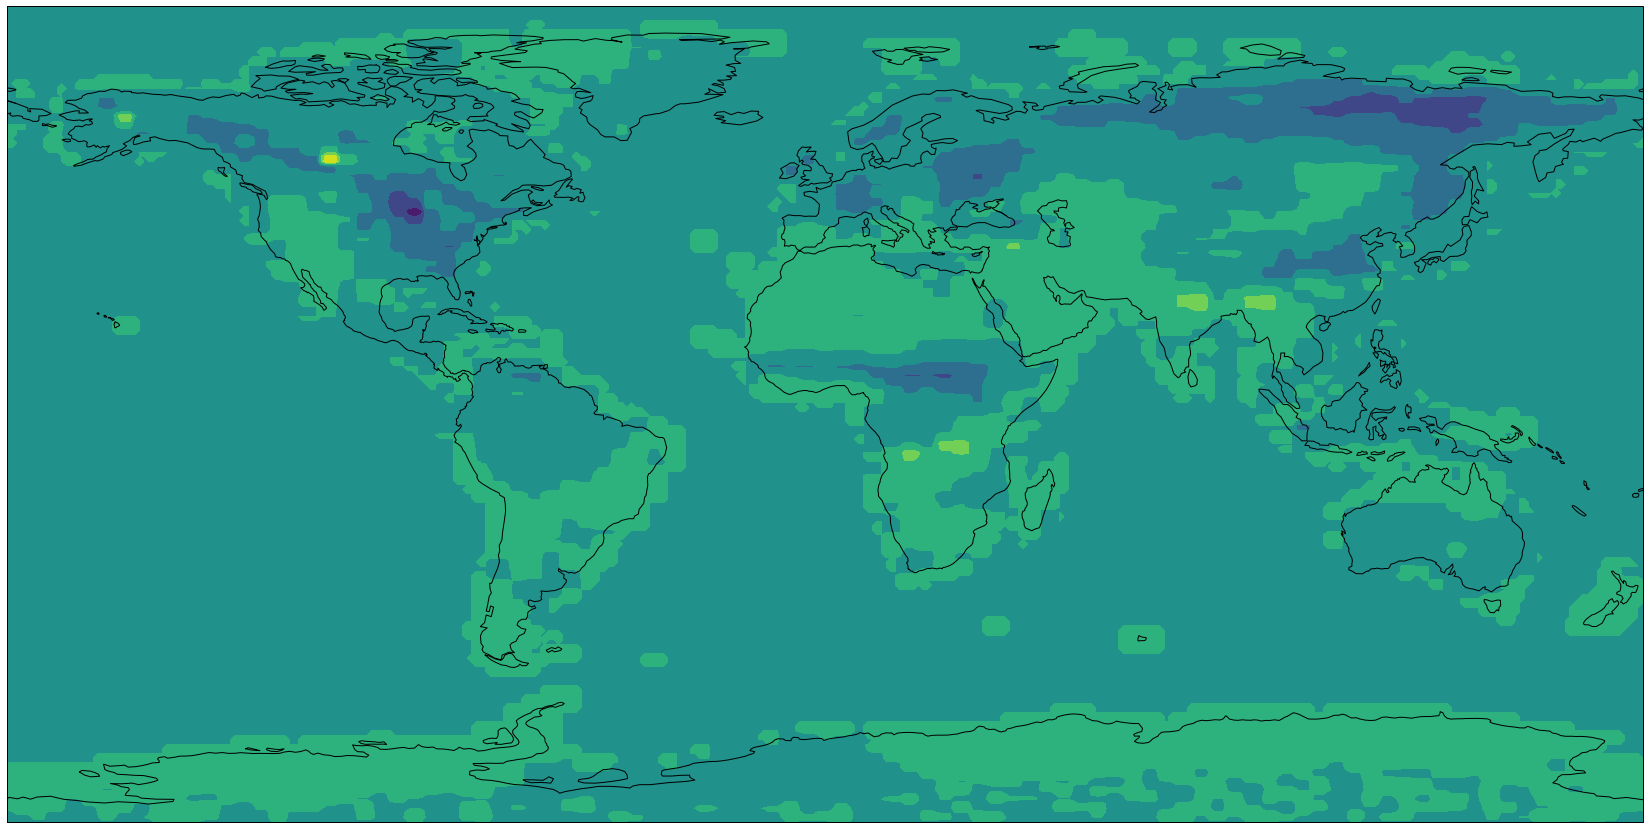

In [9]:
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.coastlines()
ax.contourf(CAMS.longitude, CAMS.latitude, CAMS.Terrestrial_flux.sel(time="2015-07").squeeze())

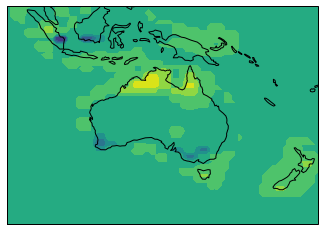

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.coastlines()
ax.contourf(CAMS_2015.longitude, CAMS_2015.latitude, CAMS_2015.Terrestrial_flux.sel(time="2015-07").squeeze())

In [12]:
CTRACKER = xr.open_dataset("./../../data/inversions/fco2_CTRACKER-EU-v2018_June2018-ext3_2000-2017_monthlymean_XYT.nc")
JAMSTEC = xr.open_dataset("./../../data/inversions/fco2_JAMSTEC-V1-2-2018_June2018-ext3_1996-2017_monthlymean_XYT.nc")
JENA_s76 = xr.open_dataset("./../../data/inversions/fco2_JENA-s76-4-2-2018_June2018-ext3_1976-2017_monthlymean_XYT.nc")
JENA_s85 = xr.open_dataset("./../../data/inversions/fco2_JENA-s85-4-2-2018_June2018-ext3_1985-2017_monthlymean_XYT.nc")

In [13]:
def main(df, name):
    df_2015 =  df.sel(time=slice("2015-01", "2015-12"),
                     latitude=slice(-56.5, 6.5),
                     longitude=slice(89.5, 190.5)
                    )
    
    df_2015.to_netcdf(f"./../{name}_2015.nc")
    
    return df_2015

In [14]:
main(CAMS, "CAMS")

<xarray.Dataset>
Dimensions:           (latitude: 64, longitude: 91, time: 12)
Coordinates:
  * longitude         (longitude) float64 89.5 90.5 91.5 ... 177.5 178.5 179.5
  * latitude          (latitude) float64 -56.5 -55.5 -54.5 -53.5 ... 4.5 5.5 6.5
  * time              (time) object 2015-01-16 00:00:00 ... 2015-12-16 00:00:00
Data variables:
    fossil            (time, latitude, longitude) float32 ...
    Terrestrial_flux  (time, latitude, longitude) float32 ...
    Ocean_flux        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      Thu Apr  4 23:44:41 2019: ncrename -a .FillValue,_FillValue...
    NCO:          "4.6.3"

In [15]:
main(CTRACKER, "CTRACKER")

<xarray.Dataset>
Dimensions:           (latitude: 64, longitude: 91, time: 12)
Coordinates:
  * longitude         (longitude) float64 89.5 90.5 91.5 ... 177.5 178.5 179.5
  * latitude          (latitude) float64 -56.5 -55.5 -54.5 -53.5 ... 4.5 5.5 6.5
  * time              (time) object 2015-01-16 00:00:00 ... 2015-12-16 00:00:00
Data variables:
    fossil            (time, latitude, longitude) float32 ...
    Terrestrial_flux  (time, latitude, longitude) float32 ...
    Ocean_flux        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      Thu Apr  4 23:49:14 2019: ncrename -a .FillValue,_FillValue...
    NCO:          "4.6.3"

In [16]:
main(JAMSTEC, "JAMSTEC")

<xarray.Dataset>
Dimensions:           (latitude: 64, longitude: 91, time: 12)
Coordinates:
  * longitude         (longitude) float64 89.5 90.5 91.5 ... 177.5 178.5 179.5
  * latitude          (latitude) float64 -56.5 -55.5 -54.5 -53.5 ... 4.5 5.5 6.5
  * time              (time) object 2015-01-16 00:00:00 ... 2015-12-16 00:00:00
Data variables:
    fossil            (time, latitude, longitude) float32 ...
    Terrestrial_flux  (time, latitude, longitude) float32 ...
    Ocean_flux        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      Fri Apr  5 00:34:11 2019: ncrename -a .FillValue,_FillValue...
    NCO:          "4.6.3"

In [17]:
main(JENA_s76, "JENA_s76")

<xarray.Dataset>
Dimensions:           (latitude: 64, longitude: 91, time: 12)
Coordinates:
  * longitude         (longitude) float64 89.5 90.5 91.5 ... 177.5 178.5 179.5
  * latitude          (latitude) float64 -56.5 -55.5 -54.5 -53.5 ... 4.5 5.5 6.5
  * time              (time) object 2015-01-16 00:00:00 ... 2015-12-16 00:00:00
Data variables:
    fossil            (time, latitude, longitude) float32 ...
    Terrestrial_flux  (time, latitude, longitude) float32 ...
    Ocean_flux        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      Fri Apr  5 00:30:48 2019: ncrename -a .FillValue,_FillValue...
    NCO:          "4.6.3"

In [18]:
main(JENA_s85, "JENA_s85")

<xarray.Dataset>
Dimensions:           (latitude: 64, longitude: 91, time: 12)
Coordinates:
  * longitude         (longitude) float64 89.5 90.5 91.5 ... 177.5 178.5 179.5
  * latitude          (latitude) float64 -56.5 -55.5 -54.5 -53.5 ... 4.5 5.5 6.5
  * time              (time) object 2015-01-16 00:00:00 ... 2015-12-16 00:00:00
Data variables:
    fossil            (time, latitude, longitude) float32 ...
    Terrestrial_flux  (time, latitude, longitude) float32 ...
    Ocean_flux        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      Fri Apr  5 00:07:44 2019: ncrename -a .FillValue,_FillValue...
    NCO:          "4.6.3"